In [2]:
!pip install datasets evaluate transformers[sentencepiece]
!pip install accelerate -U
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.8/294.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 5.8 MB/s eta 0:00:00


In [3]:
import pandas as pd
import torch
import accelerate
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
!ls gdrive/MyDrive/Collab

logs  Model  sampled_messages.csv


In [6]:
# path to labled data
data =  pd.read_csv('gdrive/MyDrive/Collab/sampled_messages.csv', encoding="latin")

In [8]:
# Split the dataset into training and validation sets
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Detect GPU availability

# Load a pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=4)  # 4 labels
model = model.to(device)

# Tokenize the commit messages
def tokenize_batch(batch):
    return tokenizer(batch['message'].tolist(), padding=True, truncation=True, return_tensors="pt")


# Convert labels to tensors
train_labels = torch.tensor(train_data.pop('label').values)
val_labels = torch.tensor(val_data.pop('label').values)

train_tokenized = tokenize_batch(train_data)
val_tokenized = tokenize_batch(val_data)


# Create PyTorch datasets
train_dataset = torch.utils.data.TensorDataset(train_tokenized['input_ids'], train_tokenized['attention_mask'], train_labels)
val_dataset = torch.utils.data.TensorDataset(val_tokenized['input_ids'], val_tokenized['attention_mask'], val_labels)

# Define training arguments
training_args = TrainingArguments(
    output_dir="gdrive/MyDrive/Collab/Model",
    num_train_epochs=3, # It was determined, that 3 epochs gives best validation loss
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    evaluation_strategy="steps",
    eval_steps=100,
    logging_dir="gdrive/MyDrive/Collab/logs",
    logging_steps=10,
    save_steps=100,
    learning_rate=2e-5,
    save_total_limit=2,
    remove_unused_columns=False,
    push_to_hub=False,
    load_best_model_at_end=True,
)

#Define a custom data collator
class CustomDataCollator:
    def __init__(self):
        pass

    def __call__(self, batch):
        # Extract the input IDs, attention masks, and labels from the batch
        input_ids = torch.stack([example[0] for example in batch])
        attention_mask = torch.stack([example[1] for example in batch])
        labels = torch.tensor([example[2] for example in batch])

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

# Initialize the custom data collator
custom_data_collator = CustomDataCollator()

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=custom_data_collator,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

# Fine-tune the model
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss
100,0.734800,0.800170
200,0.669000,0.711439
300,0.523400,0.650319
400,0.469300,0.638444


TrainOutput(global_step=495, training_loss=0.664767689175076, metrics={'train_runtime': 441.0343, 'train_samples_per_second': 8.972, 'train_steps_per_second': 1.122, 'total_flos': 1041149141839872.0, 'train_loss': 0.664767689175076, 'epoch': 3.0})

In [9]:
!ls gdrive/MyDrive/Collab/Model

checkpoint-300	checkpoint-400


0 -- Commit contains 'Why' and 'What'
1 -- Commit contains neither 'Why' nor 'What'
2 -- Commit contains 'No What'
3 -- Commit contains 'No Why'


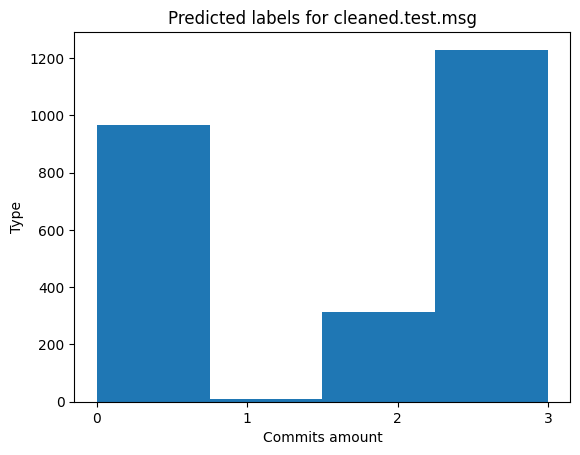

0 -- Commit contains 'Why' and 'What'
1 -- Commit contains neither 'Why' nor 'What'
2 -- Commit contains 'No What'
3 -- Commit contains 'No Why'


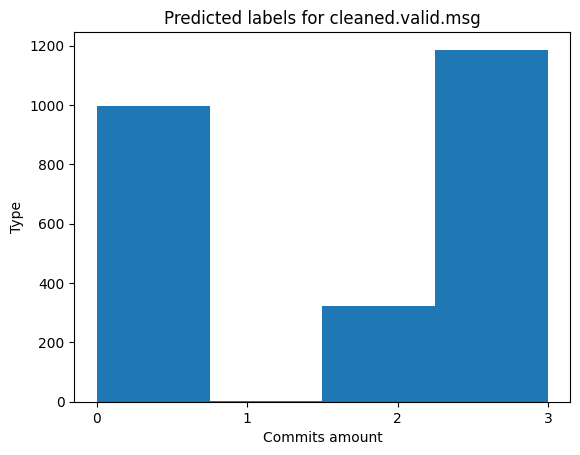

In [22]:
# Load the fine-tuned model and tokenizer
model_dir = trainer.state.best_model_checkpoint
model = BertForSequenceClassification.from_pretrained(model_dir)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Detect GPU availability

model = model.to(device)  # Move the model to the device

# Path to files with commit messages, for instance you can use https://github.com/Tbabm/nngen/tree/master/data
file_names = ["cleaned.test.msg", "cleaned.valid.msg"] # cleaned.train.msg is too large
path_to_files = "sample_data/"

for file_name in file_names:
  file_path = path_to_files + file_name

  with open(file_path, "r", encoding="utf-8") as file:
      commits = file.readlines()
  results = []

  for commit in commits:
      # Tokenize the commit text and move tensors to the same device
      inputs = tokenizer(commit, padding=True, truncation=True, return_tensors="pt").to(device)

      # Perform inference with the model
      with torch.no_grad():
          inputs = inputs.to(device)
          outputs = model(**inputs)

      # Process the model outputs as needed
      # For example, get the predicted label or probabilities
      logits = outputs.logits
      probabilities = torch.softmax(logits, dim=1)
      predicted_label = torch.argmax(probabilities, dim=1).item()

      # Store the results
      results.append({
          "commit_text": commit.strip(),  # Remove newline characters
          "predicted_label": predicted_label
      })
  # print(result) uncommit to see prediction for each commit

  result_labels = [cur_result["predicted_label"] for cur_result in results]

  print("0 -- Commit contains 'Why' and 'What'\n1 -- Commit contains neither 'Why' nor 'What'\n2 -- Commit contains 'No What'\n3 -- Commit contains 'No Why'")
  plt.hist(result_labels, bins = 4)
  plt.title("Predicted labels for " + file_name)
  plt.xlabel("Commits amount")
  plt.ylabel("Type")
  plt.xticks([0, 1, 2, 3])
  plt.show()